# Loading NWB data with electrophysiological data, analysing it, and tuning a new NeuroML model against the firing properties

## 1) Load NWB data 

In [6]:

from pynwb import NWBHDF5IO

io = NWBHDF5IO('141210c3.nwb', mode='r') # Load Fred Lanore data
nwb = io.read()



## 2) Quick examination of contents

('Frederic Lanore',)
Electrophysiological recordings from cerebellar Golgi cells

Record: Control_RecordA4: Prior to drug application; recorded voltage for -160.0nA
Record: Control_RecordA40: Prior to drug application; recorded voltage for 200.0nA


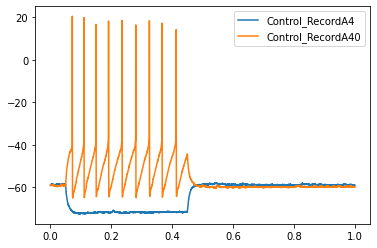

In [14]:

print(nwb.experimenter)
print(nwb.experiment_description)
print()

import matplotlib.pyplot as plt
traces = {}
times = {}

for ref in nwb.acquisition:
    if 'Control_RecordA4' in ref:
        traces[ref] = nwb.acquisition[ref].data
        times[ref] = nwb.acquisition[ref].timestamps
        print('Record: %s: %s'%(ref, nwb.acquisition[ref].description))
        plt.plot(times[ref], traces[ref], label=ref)
       
        plt.legend()

plt.show()


## 3) Analyse data using pyelectro

pyelectro >>> Calculating max_min_simple of a: (-58.92944467655073,...,-59.02099741297209)#10000, t: (0.0,...,0.9999)#10000; thresh 0, delta 0
pyelectro >>> Analysing data with 0 maxima, 0 minima 
pyelectro >>> Max: -57.95288215472286, min -72.57080240333384
pyelectro >>> Getting average of last 100 points (-58.776856782515125->-59.02099741297209) of all 10000 (-58.92944467655073->-59.02099741297209): -58.97949350579439
pyelectro >>> {   'Control_RecordA4:average_last_1percent': -58.97949350579439,
pyelectro >>>     'Control_RecordA4:max_peak_no': 0,
pyelectro >>>     'Control_RecordA4:maximum': -57.95288215472286,
pyelectro >>>     'Control_RecordA4:mean_spike_frequency': 0,
pyelectro >>>     'Control_RecordA4:min_peak_no': 0,
pyelectro >>>     'Control_RecordA4:minimum': -72.57080240333384}
pyelectro >>> Calculating max_min_simple of a: (-59.1735853070077,...,-59.81445446195724)#10000, t: (0.0,...,0.9999)#10000; thresh 0, delta 0
pyelectro >>> Spike of 20.47729537957822 at 0.0719
pye

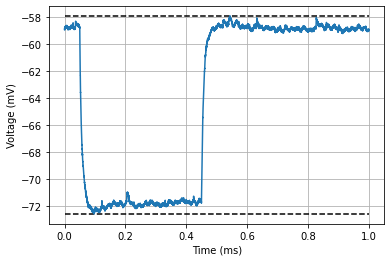

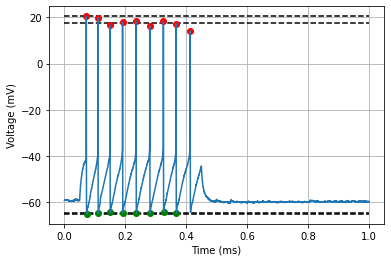

In [8]:
from pyelectro import utils

for ref in traces:

    analysis = utils.simple_network_analysis({ref:traces[ref]},
                                                     times[ref],
                                                     end_analysis=1500,
                                                     plot=True,
                                                     show_plot_already=False,
                                                     verbose=True)

## 4) Create an equivalent setup in NeuroML

pyNeuroML >>> pyneuroml.pynml - INFO - Loading NeuroML2 file: /Users/padraig/neuroConstruct/osb/showcase/NWBShowcase/IgorPro/izhikevich2007_single_cell_network.nml
pyNeuroML >>> 2021-10-26 14:25:10,043 - pyneuroml.pynml - INFO - Loading NeuroML2 file: /Users/padraig/neuroConstruct/osb/showcase/NWBShowcase/IgorPro/izhikevich2007_single_cell_network.nml
pyNeuroML >>> pyneuroml.lems.LEMSSimulation - INFO - Written LEMS Simulation example-single-izhikevich2007cell-sim to file: LEMS_example-single-izhikevich2007cell-sim.xml
pyNeuroML >>> 2021-10-26 14:25:10,053 - pyneuroml.lems.LEMSSimulation - INFO - Written LEMS Simulation example-single-izhikevich2007cell-sim to file: LEMS_example-single-izhikevich2007cell-sim.xml
pyNeuroML >>> pyneuroml.pynml - INFO - Loading LEMS file: LEMS_example-single-izhikevich2007cell-sim.xml and running with jNeuroML
pyNeuroML >>> 2021-10-26 14:25:10,056 - pyneuroml.pynml - INFO - Loading LEMS file: LEMS_example-single-izhikevich2007cell-sim.xml and running with

Written network file to: izhikevich2007_single_cell_network.nml
Validating izhikevich2007_single_cell_network.nml against /Users/padraig/anaconda/envs/py37/lib/python3.7/site-packages/libNeuroML-0.2.58-py3.7.egg/neuroml/nml/NeuroML_v2.2.xsd
It's valid!


pyNeuroML >>> pyneuroml.pynml - INFO - Command completed. Output: 
  jNeuroML >>   jNeuroML v0.11.0
  jNeuroML >>  Loading: /Users/padraig/neuroConstruct/osb/showcase/NWBShowcase/IgorPro/LEMS_example-single-izhikevich2007cell-sim.xml with jLEMS, NO GUI mode...
  jNeuroML >>  INFO Oct 26,2021 14:25  (INFO) Loading LEMS file from: /Users/padraig/neuroConstruct/osb/showcase/NWBShowcase/IgorPro/LEMS_example-single-izhikevich2007cell-sim.xml
  jNeuroML >>  INFO Oct 26,2021 14:25  (INFO) Reading from: /Users/padraig/neuroConstruct/osb/showcase/NWBShowcase/IgorPro/LEMS_example-single-izhikevich2007cell-sim.xml
  jNeuroML >>  WARNING Oct 26,2021 14:25  (WARNING) Unrecognized attribute XMLAttribute(description, Name of the property)  Name of the property at: org.lemsml.jlems.core.reader.LemsFactory.buildText(LemsFactory.java:950)
  jNeuroML >>  INFO Oct 26,2021 14:25  (LOG)  .......  last warning repeated 3 times
  jNeuroML >>  INFO Oct 26,2021 14:25  (LOG)  .......  last warning repeated 10 ti

dict_keys(['t', 0, 1])


pyNeuroML >>> pyneuroml.pynml - INFO - Saved image to example-single-izhikevich2007cell-sim-v.png of plot: Membrane potential
pyNeuroML >>> 2021-10-26 14:25:11,665 - pyneuroml.pynml - INFO - Saved image to example-single-izhikevich2007cell-sim-v.png of plot: Membrane potential


<AxesSubplot:xlabel='time (s)', ylabel='membrane potential (V)'>

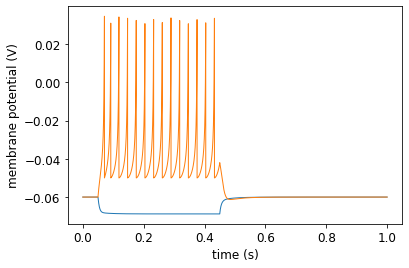

In [26]:
from neuroml import *
import neuroml.writers as writers
from neuroml.utils import validate_neuroml2
from pyneuroml import pynml
from pyneuroml.lems import LEMSSimulation
import numpy as np

# Create a new NeuroML model document
nml_doc = NeuroMLDocument(id="TestNetwork")

# Define the Izhikevich cell and add it to the model in the document
izh0 = Izhikevich2007Cell(
    id="izh2007RS0", v0="-60mV", C="100pF", k="0.7nS_per_mV", vr="-60mV",
    vt="-40mV", vpeak="35mV", a="0.03per_ms", b="-2nS", c="-50.0mV", d="100pA")
nml_doc.izhikevich2007_cells.append(izh0)

# Create a network and add it to the model
net = Network(id="IzhNet")
nml_doc.networks.append(net)

# Create a population of defined cells and add it to the model
size0 = 2
pop0 = Population(id="IzhPop0", component=izh0.id, size=size0)
net.populations.append(pop0)

# Define an external stimulus and add it to the model
pg = PulseGenerator(
    id="pulseGen_%i" % 0, delay="50ms", duration="400ms",
    amplitude="-0.16 nA"
)
nml_doc.pulse_generators.append(pg)
exp_input = ExplicitInput(target="%s[%i]" % (pop0.id, 0), input=pg.id)
net.explicit_inputs.append(exp_input)

# Define an external stimulus and add it to the model
pg1 = PulseGenerator(
    id="pulseGen_%i" % 1, delay="50ms", duration="400ms",
    amplitude="0.2 nA"
)
nml_doc.pulse_generators.append(pg1)
exp_input = ExplicitInput(target="%s[%i]" % (pop0.id, 1), input=pg1.id)
net.explicit_inputs.append(exp_input)

# Write the NeuroML model to a file
nml_file = 'izhikevich2007_single_cell_network.nml'
writers.NeuroMLWriter.write(nml_doc, nml_file)
print("Written network file to: " + nml_file)

# Validate the NeuroML model against the NeuroML schema
validate_neuroml2(nml_file)

################################################################################
## The NeuroML file has now been created and validated. The rest of the code
## involves writing a LEMS simulation file to run the model

# Create a simulation instance of the model
simulation_id = "example-single-izhikevich2007cell-sim"
simulation = LEMSSimulation(sim_id=simulation_id,
                            duration=1000, dt=0.1, simulation_seed=123)
simulation.assign_simulation_target(net.id)
simulation.include_neuroml2_file(nml_file)

# Define the output file to store simulation outputs
# we record the neuron's membrane potential
simulation.create_output_file(
    "output0", "%s.v.dat" % simulation_id
)
simulation.add_column_to_output_file("output0", 'IzhPop0[0]', 'IzhPop0[0]/v')
simulation.add_column_to_output_file("output0", 'IzhPop0[1]', 'IzhPop0[1]/v')

# Save the simulation to a file
lems_simulation_file = simulation.save_to_file()

# Run the simulation using the jNeuroML simulator
pynml.run_lems_with_jneuroml(
    lems_simulation_file, max_memory="2G", nogui=True, plot=False
)

# Load the data from the file and plot the graph for the membrane potential
# using the pynml generate_plot utility function.
data, indices = pynml.reload_standard_dat_file("%s.v.dat" % simulation_id)
print(data.keys())

pynml.generate_plot(
    [data['t'],data['t']], [data[0],data[1]],
    
    "Membrane potential", show_plot_already=False,
    save_figure_to="%s-v.png" % simulation_id,
    xaxis="time (s)", yaxis="membrane potential (V)"
)